<a href="https://colab.research.google.com/github/Team-Takeoff/Capstone/blob/Dave/models/NN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0:  Install and import necessary packages (if not currently in run-time)

Some packages were installed and run on a local machine due to constrains in the free colab environment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pyarrow

In [ ]:
!pip install scikeras

In [ ]:
!pip install tensorflow-rocm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.7/497.7 MB 3.2 MB/s eta 0:00:00


In [ ]:
#!pip install tensorflow #run only if necessary

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import save_model, load_model
import keras.metrics
import keras.losses
from keras import backend as K
import pandas as pd
import numpy as np
import json
from datetime import datetime
import pyarrow.parquet as pq
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, f1_score,roc_curve
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.metrics import make_scorer
import tensor_transformer
from NN_model import custom_f1, XTransform
# recall_m, precision_m, f1_new
import joblib
from copy import deepcopy
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

ImportError: ignored

In [ ]:
metrics_path =''
files = json.load(open('files.json','r'))

## Step 1: Data Inspection and Preparation

### The code for this notebook draws from the following source:
https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/

In [ ]:
tf.random.set_seed(42)
pd.set_option('display.max_columns', 130)
pd.set_option('display.max_rows', 200)
pd.options.display.min_rows = 120

In [ ]:
# Toggling between a few different datasets
# df = pd.read_parquet('/content/drive/Shareddrives/STUDENT-Capstone SS23/BTS_data/OnTime_WithWeather/Training_set.parquet')
df_all = pd.read_parquet(files['Final_Sets']['Training']['Train_All'])
X = pd.read_parquet('data/X.parquet')
X_train = pd.read_parquet('data/X_train.parquet')
X_val = pd.read_parquet('data/X_dev.parquet')


In [ ]:
np.bincount(df_all.Weather_Label)

array([288826,   4346])

In [ ]:
train_cols = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'OriginAirportSeqID', 'DestAirportSeqID', 'Dest', 'DestStateFips', 'CRSElapsedTime', 'Distance', 'DistanceGroup', 'Reporting_Airline_AA',
 'Reporting_Airline_AS', 'Reporting_Airline_B6', 'Reporting_Airline_CO', 'Reporting_Airline_DL', 'Reporting_Airline_F9', 'Reporting_Airline_FL', 'Reporting_Airline_MQ', 'Reporting_Airline_NK',
 'Reporting_Airline_UA', 'Reporting_Airline_US', 'Reporting_Airline_VX', 'mfr_AIRBUS', 'mfr_BOEING', 'mfr_MCDONNELL', 'mfr_nan', 'engine_type_Reciprocating',
 'engine_type_Turbofan', 'engine_type_Turbojet', 'w_type_9', 'w_type_C', 'w_type_N', 'w_type_V', 'sky_c_det_9', 'sky_c_det_C', 'sky_c_det_M', 'sky_c_det_W',
 'sky_cov_00', 'sky_cov_02', 'sky_cov_04', 'sky_cov_07', 'sky_cov_08', 'sky_cov_09', 'sky_cov_10', 'sky_obs_tot_cov_00', 'sky_obs_tot_cov_01',
 'sky_obs_tot_cov_02', 'sky_obs_tot_cov_04', 'sky_obs_tot_cov_06', 'sky_obs_tot_cov_07', 'sky_obs_tot_cov_08', 'sky_obs_tot_cov_09', 'w_type_d_9',
 'w_type_d_C', 'w_type_d_N', 'w_type_d_V', 'sky_c_det_d_9', 'sky_c_det_d_C', 'sky_c_det_d_M', 'sky_c_det_d_W', 'sky_cov_d_00', 'sky_cov_d_02',
 'sky_cov_d_04', 'sky_cov_d_07', 'sky_cov_d_08', 'sky_cov_d_09', 'sky_cov_d_10', 'sky_obs_tot_cov_d_00', 'sky_obs_tot_cov_d_01', 'sky_obs_tot_cov_d_02',
 'sky_obs_tot_cov_d_03', 'sky_obs_tot_cov_d_04', 'sky_obs_tot_cov_d_06', 'sky_obs_tot_cov_d_07', 'sky_obs_tot_cov_d_08', 'sky_obs_tot_cov_d_09', 'CRSDepHour',
 'passengers', 'no_engines', 'w_dir_angle', 'w_speed_rate', 'sky_c_hgt', 'vis_dist', 'tmp_air', 'tmp_dew', 'sea_lvl_p', 'liq_precip_qty', 'liq_precip_dim',
 'liq_precip_cond', 'sky_cov_base_hgt', 'sky_cov_cld', 'sky_sum_cov', 'sky_sum_hgt', 'sky_low_cld_base_hgt', 'at_pres_altimeter_rate', 'at_pres_stn_rate',
 'w_dir_angle_d', 'w_speed_rate_d', 'sky_c_hgt_d', 'vis_dist_d', 'tmp_air_d', 'tmp_dew_d', 'sea_lvl_p_d', 'liq_precip_qty_d', 'liq_precip_dim_d', 'liq_precip_cond_d',
 'sky_cov_base_hgt_d', 'sky_cov_cld_d', 'sky_sum_cov_d', 'sky_sum_hgt_d', 'sky_low_cld_base_hgt_d', 'at_pres_altimeter_rate_d', 'at_pres_stn_rate_d']

In [ ]:

# We initially had our train/validation split in the following manner: 2010-end of 2018 was our training data and 2019 was our validation when planning for Time sequence RNN
# We later combined the data and split using train_test_split. Furthermore, different datasets had weights vs didn't.

y_train = X_train['Weather_Label']

if 'weights' in X_train.columns:
    weights = X_train['weights']
    if 'Weather_Label' in X_train.columns:
        X_train = X_train.drop(['Weather_Label','weights'], axis=1)



else:
    weights = np.ones(len(y_train))
    weights[y_train == 0] = len(y_train) / sum(y_train == 0)
    if 'Weather_Label' in X_train.columns:
        X_train = X_train.drop(['Weather_Label'], axis=1)


y_val = X_val['Weather_Label']
X_val.drop('Weather_Label',axis=1, inplace=True)

In [ ]:
# weights = np.ones(len(y_train))
# weights[y_train == 1] = len(y_train) / sum(y_train == 1)
# X_train = df_all[df_all.index.isin(X_indexes)][train_cols]
# X_train.shape

In [ ]:
# This plugs all of the weights for both train/dev into one
# dev_weights = np.ones(len(y_val))
# dev_weights[y_val==0] = .6

# all_weights = np.concatenate([weights.values, dev_weights])

In [ ]:
print('Breakdown of Non-Delay(0) and Delay(1)')
print(np.bincount(y_train.values))

Breakdown of Non-Delay(0) and Delay(1)
[17407  3482]


In [ ]:
# shape comparison btn training and val data
X_train.shape, X_val.shape,

((20889, 115), (5223, 115))

## Step 2: Model Development

In [ ]:
# Creation of model function that will be called by keras classifier instance.
# We can set initial variables here or pass them through the classifier



neurons = 115
batch_size = 64
epochs=100
dropout_rate = .01
k=5


metrics=[
            custom_f1
        ]


def create_model(dropout_rate=.01,learning_rate=.01, batch_size=512, output_bias=-4.19656855):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model= Sequential()
    model.add(Dense(neurons, input_shape=(neurons,), activation='relu'))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(75, activation='relu'))
    # model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid', bias_initializer=output_bias))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
                  # loss=keras.losses.BinaryFocalCrossentropy(alpha=.02, apply_class_balancing=True),
                  loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics,
                  weighted_metrics=metrics
                )
    return model

In [ ]:
# get initial bias and class weights
# formula & code obtained from https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

y_all = df_all['Weather_Label']

neg, pos = np.bincount(y_all)
total = len(y_all)
weight_for_1 = (1 / pos) * (total / 2.0)
weight_for_0 = (1 / neg) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
initial_bias = np.log([pos/neg])
initial_bias

array([-4.19656855])

In [ ]:
# check weights
weight_for_1,weight_for_0

(33.728946157386105, 0.5075235608982571)

In [ ]:
# Create the KerasClassifier object so we have access to sklearn functionality

estimator = KerasClassifier(model=create_model,
                            epochs=100,
                            verbose=1,
                            dropout_rate=0.001,
                            learning_rate=0.001,
                            batch_size=512,
                            validation_split=.2,
                            shuffle=True,
                            random_state=42,
                            class_weight=None,
                            # weight_decay=1,
                            output_bias=-4.19656855)

In [ ]:
# Create Pipeline,parameters and the metrics we'd like to iterate on.


params =  {
          'model__learning_rate': [.001,.005,.01,.05,.1],
          'model__dropout_rate': [.001, .01, .05,.1],
          'model__batch_size': [128]

        }


rep_cols = {
        'dub_cols' : ['liq_precip_qty_d'],
        'trip_cols' : ['w_dir_angle', 'w_dir_angle_d'],
        'quad_cols' : ['w_speed_rate','tmp_air','tmp_dew','liq_precip_dim','w_speed_rate_d','tmp_air_d','tmp_dew_d','liq_precip_dim_d'],
        'quin_cols' : ['sky_c_hgt','sea_lvl_p','sky_cov_base_hgt','sky_sum_hgt','sky_low_cld_base_hgt',
                     'at_pres_altimeter_rate','at_pres_stn_rate','sky_c_hgt_d', 'sea_lvl_p_d','sky_cov_base_hgt_d',
                     'sky_sum_hgt_d','sky_low_cld_base_hgt_d','at_pres_altimeter_rate_d','at_pres_stn_rate_d'],
        'sext_cols' :  ['vis_dist','vis_dist_d']}


scale_cols = ['CRSElapsedTime', 'Distance', 'passengers', 'OriginAirportSeqID','DestAirportSeqID',
               'w_dir_angle','w_speed_rate','sky_c_hgt','vis_dist','tmp_air','tmp_dew',
              'sea_lvl_p','liq_precip_qty','liq_precip_dim','sky_cov_base_hgt','sky_cov_cld','sky_sum_cov','sky_sum_hgt',
              'sky_low_cld_base_hgt','at_pres_altimeter_rate','at_pres_stn_rate','w_dir_angle_d',
              'w_speed_rate_d','sky_c_hgt_d','vis_dist_d','tmp_air_d','tmp_dew_d',
              'sea_lvl_p_d','liq_precip_qty_d','liq_precip_dim_d','liq_precip_cond_d','sky_cov_base_hgt_d',
              'sky_cov_cld_d', 'sky_sum_cov_d','sky_sum_hgt_d','sky_low_cld_base_hgt_d','at_pres_altimeter_rate_d',
              'at_pres_stn_rate_d','Year'
             ]


stdscales = ColumnTransformer(transformers=[('scalers',StandardScaler(),scale_cols)],
                              remainder='passthrough',
                              verbose_feature_names_out=False).set_output(transform='pandas')

pipe = Pipeline(steps=[
                       # ('replace',mis_replace),
                       ('scale', stdscales),
                       ('tensor',XTransform()),
                       ('model',estimator)
                      ])


scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=1),
    'recall': make_scorer(recall_score, average='macro',zero_division=1),
    'f1': make_scorer(f1_score,greater_is_better=True, average='weighted'),
}


# Can use RandomizedSearch or GridSearch (see below)
rand_search = RandomizedSearchCV(estimator,
                                 param_distributions=params,
                                 n_iter=10,
                                 scoring=scoring,
                                 n_jobs=-1,
                                 refit='f1',
                                 cv=5,
                                 random_state=42,
                                 return_train_score=True)




In [ ]:
# Helper function to see metrics, and visualizations. Used for both training and validation data

def generate_matrix(y_true,predictions, y_pred_probability,model):
    name='test'
    print('Accuracy:', accuracy_score(y_true,predictions))
    print('Precision:', precision_score(y_true, predictions, average='weighted'))
    print('Recall:', recall_score(y_true, predictions, average='weighted'))
    print('F1 Score:', f1_score(y_true, predictions, average='weighted'))
    print('AUC Score:', roc_auc_score(y_true,y_pred_probability,average='weighted'))
    fpr, tpr, thres = roc_curve(y_true, y_pred_probability)
    roc = RocCurveDisplay(fpr=fpr, tpr=tpr,estimator_name=name)
    p,r,t = precision_recall_curve(y_true,y_pred_probability)
    prplot = PrecisionRecallDisplay(p,r)
    cm = confusion_matrix(y_true,predictions,labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=[0,1])

    disp.plot()
    prplot.plot()
    roc.plot()
    plt.show()

## Run GridSearch on Parameters

In [ ]:
# Run gridsearch on above parameter dictionary

grid = GridSearchCV(pipe,params,
                    cv=5,
                    n_jobs=-1,
                    scoring= scoring,
                    return_train_score=True,
                    refit='f1',
                    verbose=1)



results = grid.fit(X_train,
                   y_train,
                   # model__batch_size=2048,
                   model__sample_weight=weights
                  )


Fitting 5 folds for each of 20 candidates, totalling 100 fits


2023-07-31 23:26:01.125622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 23:26:01.155073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 23:26:01.160681: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 23:26:01.164062: I tensorflow

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
105/105 [==============================] - 2s 11ms/step - loss: 1.2766 - custom_f1: 0.3637 - weighted_custom_f1: 0.3677 - val_loss: 1.0825 - val_custom_f1: 0.4207 - val_weighted_custom_f1: 0.4259
Epoch 2/100
105/105 [==============================] - 2s 11ms/step - loss: 1.2552 - custom_f1: 0.3808 - weighted_custom_f1: 0.3846 - val_loss: 1.0982 - val_custom_f1: 0.4041 - val_weighted_custom_f1: 0.4014
Epoch 2/100
105/105 [==============================] - 2s 11ms/step - loss: 1.2484 - custom_f1: 0.3700 - weighted_custom_f1: 0.3745 - val_loss: 1.1180 - val_custom_f1: 0.3705 - val_weighted_custom_f1: 0.3809
Epoch 2/100
Epoch 2/100
105/105 [==============================] - 2s 11ms/step - loss: 1.2162 - custom_f1: 0.4042 - weighted_custom_f1: 0.4081 - val_loss: 1.1143 - val_custom_f1: 0.3997 - val_wei

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



105/105 [==============================] - 0s 2ms/step - loss: 1.0311 - custom_f1: 0.4755 - weighted_custom_f1: 0.4801 - val_loss: 1.1777 - val_custom_f1: 0.4668 - val_weighted_custom_f1: 0.4597
Epoch 50/100
105/105 [==============================] - 0s 2ms/step - loss: 0.9600 - custom_f1: 0.5020 - weighted_custom_f1: 0.5028 - val_loss: 1.1309 - val_custom_f1: 0.4819 - val_weighted_custom_f1: 0.4760
Epoch 50/100
105/105 [==============================] - 0s 2ms/step - loss: 1.2652 - custom_f1: 0.2716 - weighted_custom_f1: 0.2750 - val_loss: 1.4261 - val_custom_f1: 0.2789 - val_weighted_custom_f1: 0.2889
Epoch 56/100
105/105 [==============================] - 0s 2ms/step - loss: 0.9729 - custom_f1: 0.4892 - weighted_custom_f1: 0.4930 - val_loss: 1.2514 - val_custom_f1: 0.4931 - val_weighted_custom_f1: 0.4945
Epoch 53/100
105/105 [==============================] - 0s 2ms/step - loss: 1.0031 - custom_f1: 0.4822 - weighted_custom_f1: 0.4864 - val_loss: 1.0408 - val_custom_f1: 0.4402 - val_

## Model Performance Review

Optimize for F1 but looked at several metrics in tandem.

In [ ]:
# Obtain metrics from each model run
metrics = pd.DataFrame(results.cv_results_)
param_cols = [x for x in metrics.columns if 'param_model' in x]
metric_cols = [x for x in metrics.columns if 'mean_test' in x] + ['rank_test_f1', ] + param_cols
metrics[metric_cols].sort_values('rank_test_f1').T


,1,6,11,16,2,17,7,12,0,5,10,15,3,8,18,13,9,4,14,19
mean_test_accuracy,0.807076,0.807076,0.807076,0.807076,0.802241,0.802241,0.802241,0.802241,0.798411,0.798411,0.798411,0.798411,0.745415,0.745415,0.745415,0.745415,0.6176,0.6176,0.6176,0.6176
mean_test_precision,0.683131,0.683131,0.683131,0.683131,0.680732,0.680732,0.680732,0.680732,0.679088,0.679088,0.679088,0.679088,0.663951,0.663951,0.663951,0.663951,0.636317,0.636317,0.636317,0.636317
mean_test_recall,0.737216,0.737216,0.737216,0.737216,0.740519,0.740519,0.740519,0.740519,0.740066,0.740066,0.740066,0.740066,0.75765,0.75765,0.75765,0.75765,0.682731,0.682731,0.682731,0.682731
mean_test_f1,0.81954,0.81954,0.81954,0.81954,0.816267,0.816267,0.816267,0.816267,0.813328,0.813328,0.813328,0.813328,0.773651,0.773651,0.773651,0.773651,0.616964,0.616964,0.616964,0.616964
rank_test_f1,1,1,1,1,5,5,5,5,9,9,9,9,13,13,13,13,17,17,17,17
param_model__batch_size,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128
param_model__dropout_rate,0.001,0.01,0.05,0.1,0.001,0.1,0.01,0.05,0.001,0.01,0.05,0.1,0.001,0.01,0.1,0.05,0.01,0.001,0.05,0.1
param_model__learning_rate,0.005,0.005,0.005,0.005,0.01,0.01,0.01,0.01,0.001,0.001,0.001,0.001,0.05,0.05,0.05,0.05,0.1,0.1,0.1,0.1


164/164 [==============================] - 0s 679us/step
Accuracy: 0.8805112738762028
Precision: 0.9087748692102907
Recall: 0.8805112738762028
F1 Score: 0.8887191587661427
AUC Score: 0.9389910348873957


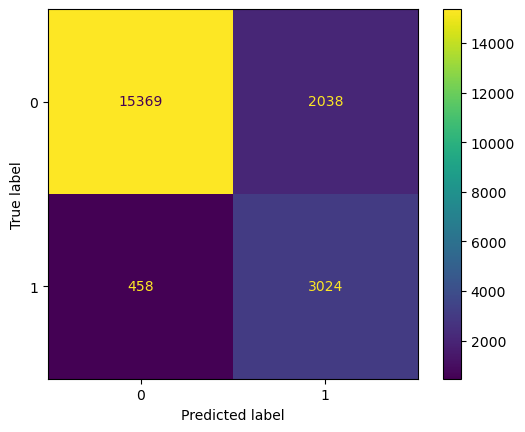

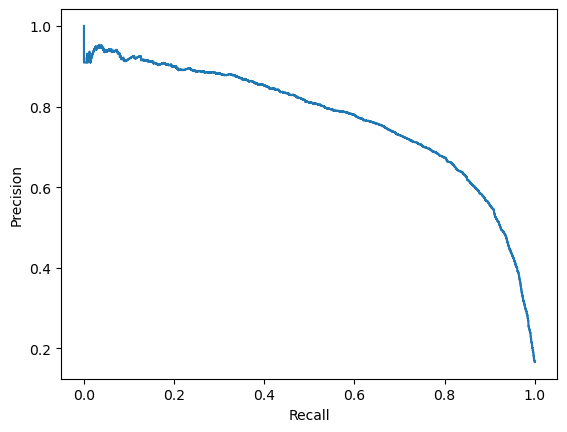

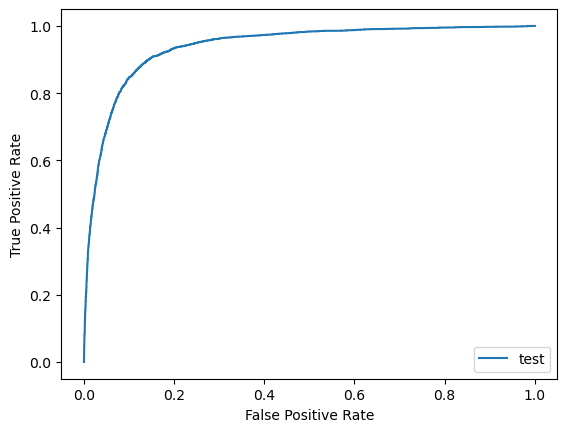

In [ ]:
y_preds = results.predict(X_train)
y_preds_proba = results.predict_proba(X_train)[:,1]
generate_matrix(y_train, y_preds, y_preds_proba,_)

41/41 [==============================] - 0s 757us/step
Accuracy: 0.8238560214436148
Precision: 0.8528618417077554
Recall: 0.8238560214436148
F1 Score: 0.8346240930977888
AUC Score: 0.830093791835991


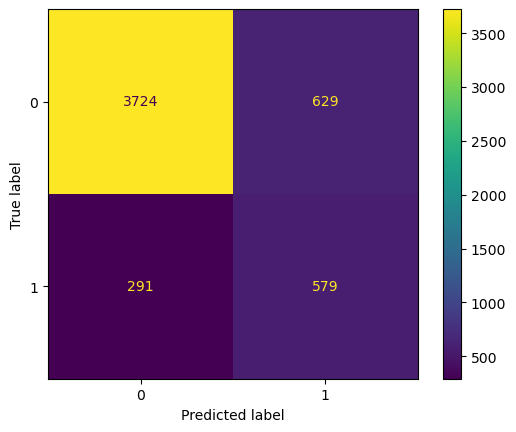

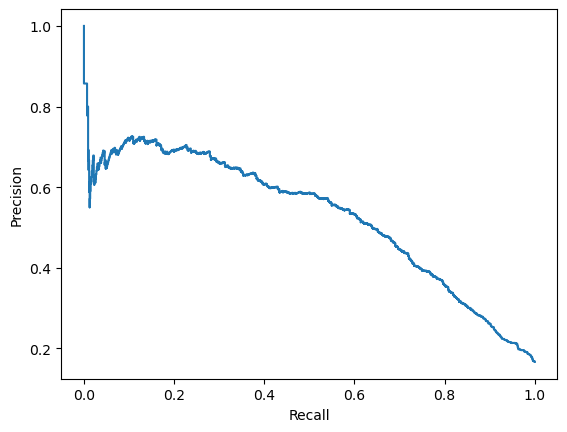

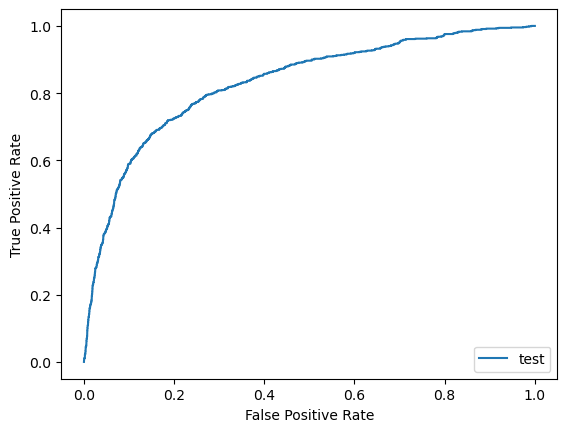

In [ ]:
y_preds = results.predict(X_val)
y_preds_proba = results.predict_proba(X_val)[:,1]
generate_matrix(y_val, y_preds, y_preds_proba,_)

## Statistical Test to Determine Representativness

In [ ]:
y = np.concatenate((y_train,y_val))
y_neg, y_pos = np.bincount(y)
print(y_neg, y_pos)
y_all = df_all['Weather_Label']
y_neg_all, y_pos_all = np.bincount(y_all)

df = pd.DataFrame({'Class': ['Neg','Pos','Neg','Pos'],
             'Set': ['Downsample','Downsample','Full','Full'],
              'Counts': [y_neg, y_pos, y_neg_all, y_pos_all] }

                 )

df

21760 4352


,Class,Set,Counts
0,Neg,Downsample,21760
1,Pos,Downsample,4352
2,Neg,Full,288826
3,Pos,Full,4346


In [ ]:
c_table = pd.crosstab(df['Class'], df['Set'], values=df['Counts'], aggfunc='first')
c_table

Set,Downsample,Full
Class,,
Neg,21760,288826
Pos,4352,4346


In [ ]:
import scipy.stats as stats
res = stats.chi2_contingency(c_table)
res.pvalue

0.0

## Fit New (Final) Model with Combined Train + Val Data
Once best parameters are obtained, re-run over the combined train + val dataset.

In [ ]:
y=X['Weather_Label']
weights = X['weights']
X.drop(['Weather_Label','weights'],axis=1,inplace=True)

In [ ]:
new_estimator = KerasClassifier(model=create_model,
                            epochs=100,
                            verbose=1,
                            dropout_rate=0.001,
                            learning_rate=0.005,
                            batch_size=128,
                            validation_split=.2,
                            shuffle=True,
                            random_state=42,
                            class_weight=None,
                            output_bias=-4.19656855)

In [ ]:
params = {}


pipe_all = Pipeline(steps=[
                       # ('replace',mis_replace),
                       ('scale', stdscales),
                       ('tensor',XTransform()),
                       ('model',new_estimator)
                      ])


grid = GridSearchCV(pipe_all,params,
                    cv=2,
                    n_jobs=-1,
                    scoring= scoring,
                    return_train_score=True,
                    refit='f1',
                    verbose=1)



results = grid.fit(X,
                   y,
                   # model__batch_size=2048,
                   model__sample_weight=weights
                  )


Fitting 2 folds for each of 1 candidates, totalling 2 fits


2023-08-04 17:27:16.314693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-04 17:27:16.314864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
Epoch 1/100
82/82 [==============================] - 1s 4ms/step - loss: 1.2709 - custom_f1: 0.3927 - weighted_custom_f1: 0.3977 - val_loss: 1.1195 - val_custom_f1: 0.4672 - val_weighted_custom_f1: 0.4766
Epoch 2/100
82/82 [==============================] - 1s 4ms/step - loss: 1.3069 - custom_f1: 0.3742 - weighted_custom_f1: 0.3776 - val_loss: 1.0918 - val_custom_f1: 0.3566 - val_weighted_custom_f1: 0.3889
Epoch 2/100
82/82 [==============================] - 0s 2ms/step - loss: 1.0416 - custom_f1: 0.4395 - weighted_custom_f1: 0.4439 - val_loss: 1.1120 - val_custom_f1: 0.4669 - val_weighted_custom_f1: 0.4737
Epoch 3/100
82/82 [==============================] - 0s 2ms/step - loss: 1.1472 - custom_f1: 0.4240 - weighted_custom_f1: 0.4287 - val_loss: 1.0953 - val_custom_f1: 0.4164 - val_weighted_custom_f1: 0.4512
Epoch 3/100
82/82 [==============================] - 0s 2ms/step - loss: 1.0118 - custom_f1: 0.4578 - weighted_custom_f1: 0.4614 - val_loss: 1.1515 - val_custom_f1: 0.4

In [ ]:
# Run the pipeline and pass the transformed data to be fit.
best = results.best_estimator_
X_scaled = best.named_steps['scale'].fit_transform(X)
X_trans = best.named_steps['tensor'].fit_transform(X_scaled)


In [ ]:
pd.DataFrame(results.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_accuracy,split1_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,mean_train_f1,std_train_f1
0,14.214009,0.199316,0.251523,0.006333,{},0.76777,0.770374,0.769072,0.001302,1,0.850184,0.856541,0.853362,0.003179,0.659264,0.660149,0.659706,0.000442,1,0.755285,0.761655,0.75847,0.003185,0.740074,0.739246,0.73966,0.000414,1,0.878676,0.884145,0.881411,0.002734,0.790695,0.792593,0.791644,0.000949,1,0.864448,0.869872,0.86716,0.002712


204/204 [==============================] - 0s 673us/step
Accuracy: 0.8765701593137255
Precision: 0.9087134854485702
Recall: 0.8765701593137255
F1 Score: 0.8856501453981707
AUC Score: 0.9390410320981565


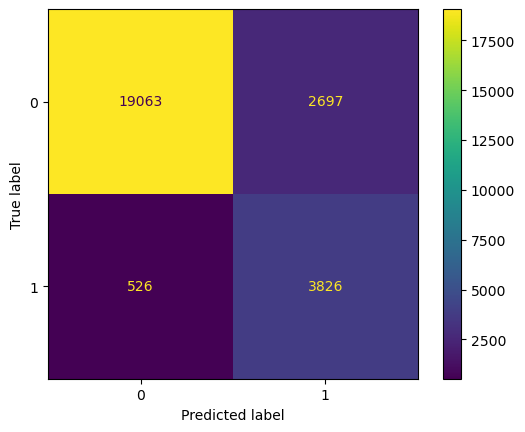

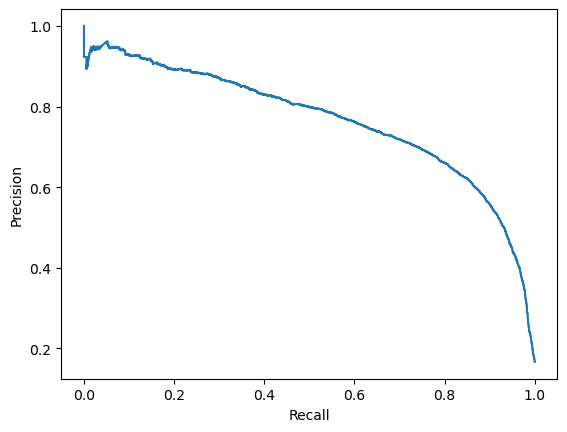

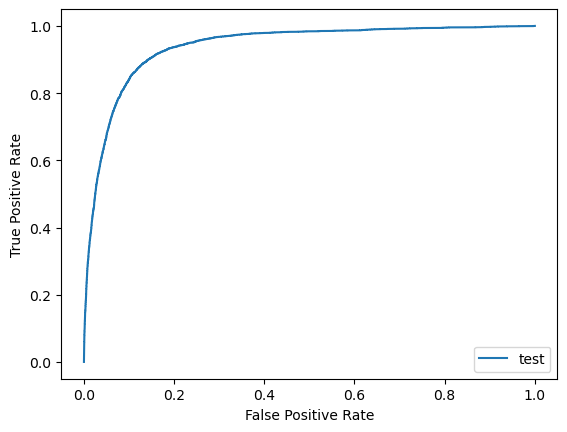

In [ ]:
y_preds = results.predict(X)
y_preds_proba =results.predict_proba(X)[:,1]
generate_matrix(y, y_preds, y_preds_proba,_)

In [ ]:
results.best_estimator_.named_steps['model']

KerasClassifier(
	model=<function create_model at 0x7f7c820f01f0>
	build_fn=None
	warm_start=False
	random_state=42
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=128
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
	dropout_rate=0.001
	learning_rate=0.005
	output_bias=-4.19656855
	class_weight=None
)

## Saving Final Model and Pipeline

In [ ]:
import joblib

In [ ]:
# Code provided by https://stackoverflow.com/questions/37984304/how-to-save-a-scikit-learn-pipline-with-keras-regressor-inside-to-disk
best_model = results.best_estimator_

# Save the Keras model first:
# results.best_estimator_.model_.save('best_model.h5')
best_model.named_steps['model'].model_.save('best_model.h5')

# This hack allows us to save the sklearn pipeline:
best_model.named_steps['model'].model_ = None

# Finally, save the pipeline:
joblib.dump(best_model, 'sklearn_pipeline.pkl')


/Users/davidboudia/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['sklearn_pipeline.pkl']

In [ ]:
new_estimator

KerasClassifier(
	model=<function create_model at 0x7f7faa029480>
	build_fn=None
	warm_start=False
	random_state=42
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=128
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=100
	dropout_rate=0.001
	learning_rate=0.005
	output_bias=[-4.19656855]
	class_weight=None
)

## Feature Importance From Training

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
r = permutation_importance(results.best_estimator_, X_val, y_val.values.reshape(-1,),n_repeats=30,random_state=0)

41/41 [==============================] - 0s 639us/step


In [ ]:
feats = dict(zip(list(X_val.columns[np.argsort(r.importances_mean)[::-1]])
                 ,r.importances_mean[np.argsort(r.importances_mean)[::-1]]))
top_features = dict(sorted(feats.items(), key=lambda x: x[1], reverse=True)[:20])

pd.DataFrame(data=top_features.items(),columns=['feature','importance'])



,feature,importance
0,DayofMonth,0.048523
1,tmp_dew,0.034961
2,CRSDepHour,0.032982
3,Dest,0.032810
4,tmp_air,0.030927
5,sky_c_hgt,0.029779
6,Month,0.025081
7,w_speed_rate,0.024705
8,Year,0.024692
9,DayOfWeek,0.021629
